In [1]:
import pandas as pd
import numpy as np
import matplotlib

# import the celeb csv file.
comments_df = pd.read_csv('../../datasets/raw/youtube_comments.csv')

# import celeb csv file.
celeb_df = pd.read_csv("../../datasets/attendees.csv")

# check is imported.
comments_df.head(5)
celeb_df.head(5)

,Name,Year,Gender
0,Billie Eilish,2021,Unknown
1,A$AP Rocky,2021,Male
2,Rihanna,2021,Female
3,Jennifer Lopez,2021,Female
4,Lil Nas X,2021,Male


Attendees CSV columns: ['Name', 'Year', 'Gender']
Comments CSV columns: ['video_id', 'text', 'author', 'likes', 'date', 'time', 'year', 'met_gala_year']

Loaded celebrity attendance data for 418 celebrities:
  billie eilish eilish: [2021, 2022]
  a ap rocky: [2021, 2023, 2025]
  rihanna: [2021, 2023, 2025]
  jennifer lopez: [2021, 2023]
  lil nas x: [2021, 2023, 2024]
  lorde: [2021, 2025]
  timothée chalamet: [2021]
  iman: [2021]
  kaia gerber: [2021, 2022]
  kendall jenner: [2021, 2022, 2023, 2024, 2025]
  ... and 408 more
Loaded 418 celebrity names
Created 418 search patterns (full names only)
Loaded 72076 comments

=== Processing All Years ===
Processing 72076 comments...

=== All Years Co-mention Graph Summary ===
Total comments processed: 72076
Total celebrity mentions: 8591
Comments with multiple celebrity mentions: 653
Nodes (Celebrities): 232
Edges (Co-mentions): 2453

--- Top 10 Celebrity Co-mentions (All Years) ---
1. Zendaya & Diana Ross: 28 co-mentions
2. Rihanna & Lil Na

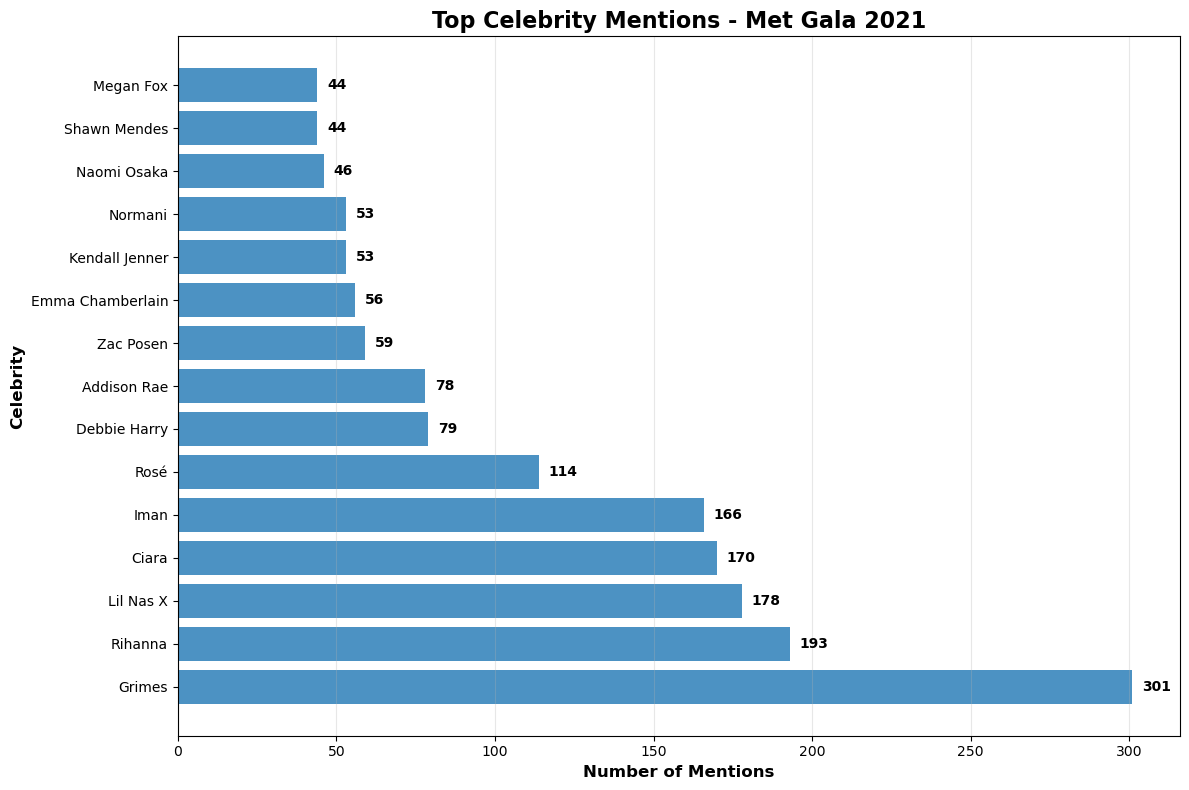

Saved 2022 celebrity mentions chart: comention_graphs/celebrity_mentions_2022.png


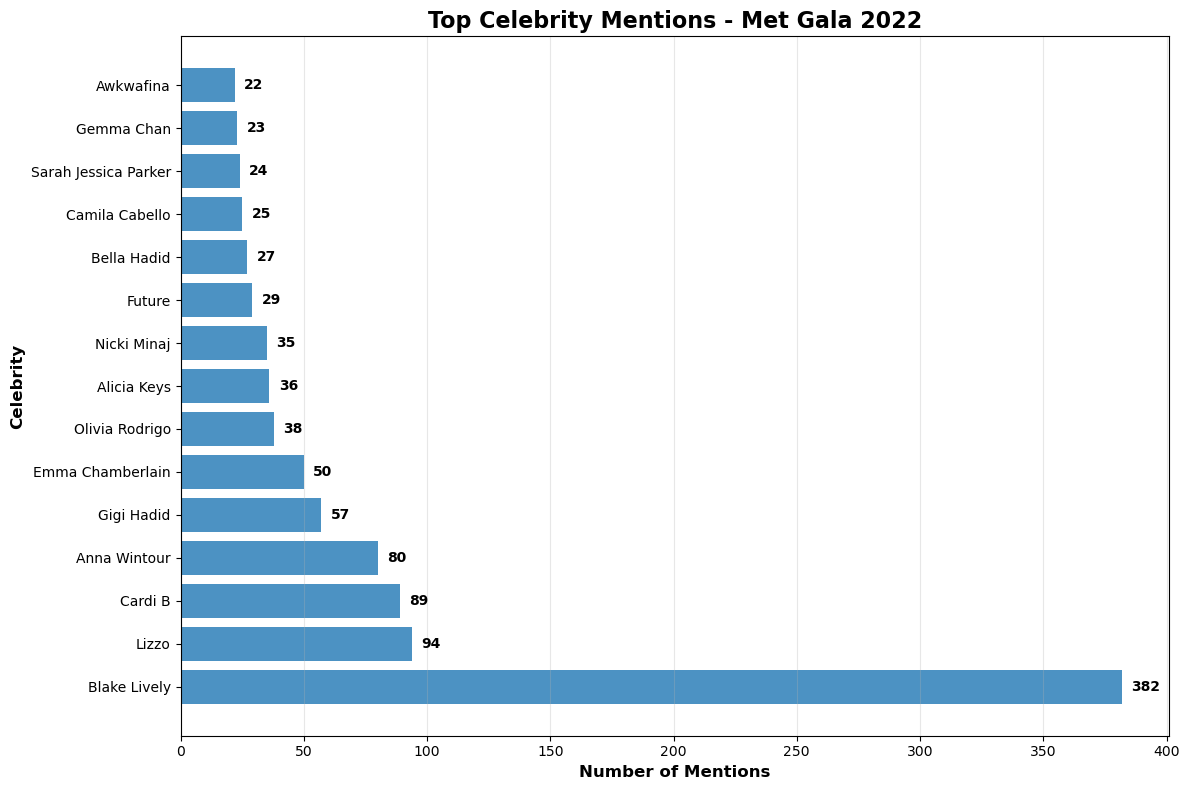

Saved 2023 celebrity mentions chart: comention_graphs/celebrity_mentions_2023.png


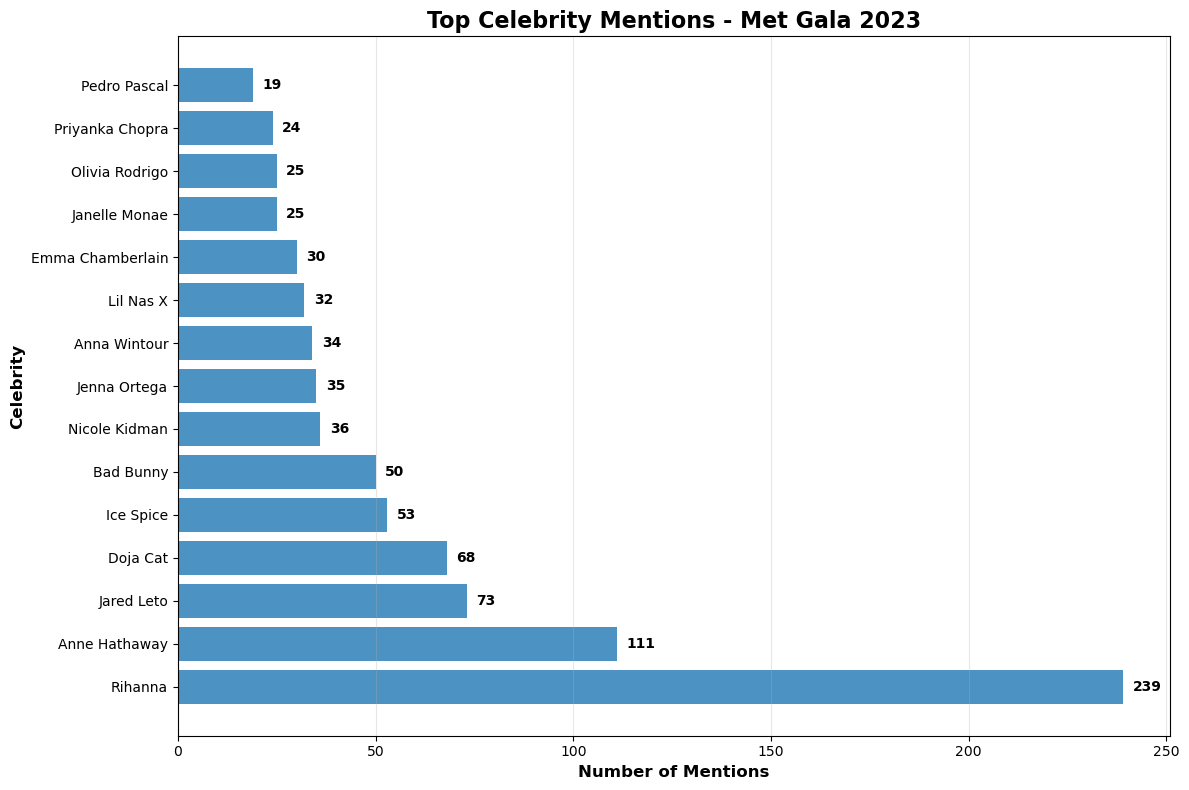

Saved 2024 celebrity mentions chart: comention_graphs/celebrity_mentions_2024.png


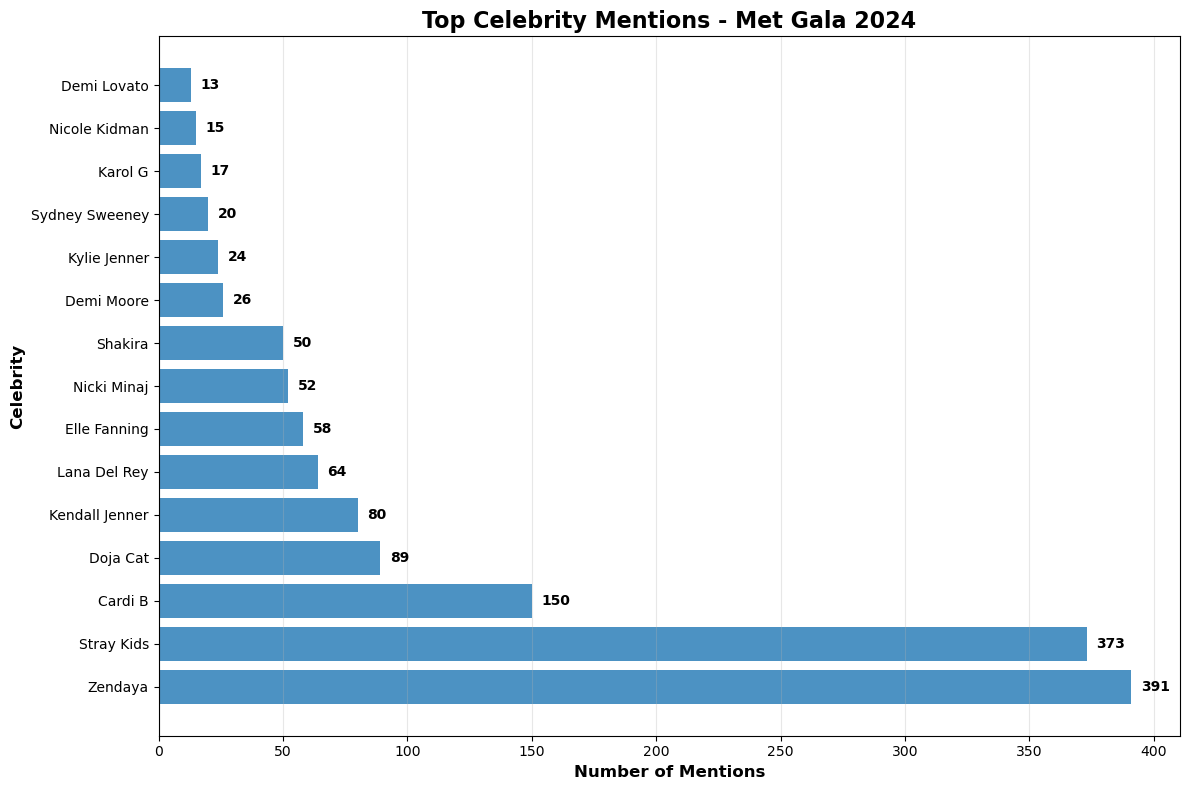

Saved 2025 celebrity mentions chart: comention_graphs/celebrity_mentions_2025.png


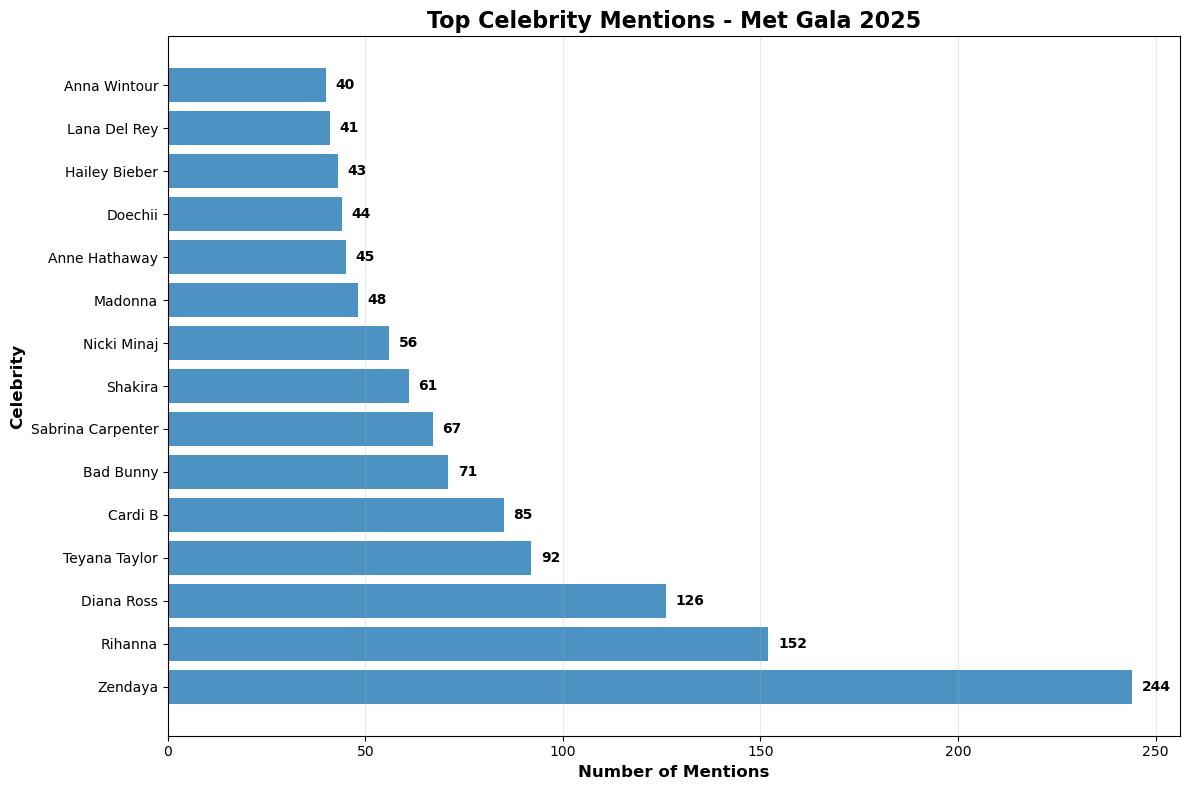

Saved all years celebrity mentions chart: comention_graphs/celebrity_mentions_all_years.png


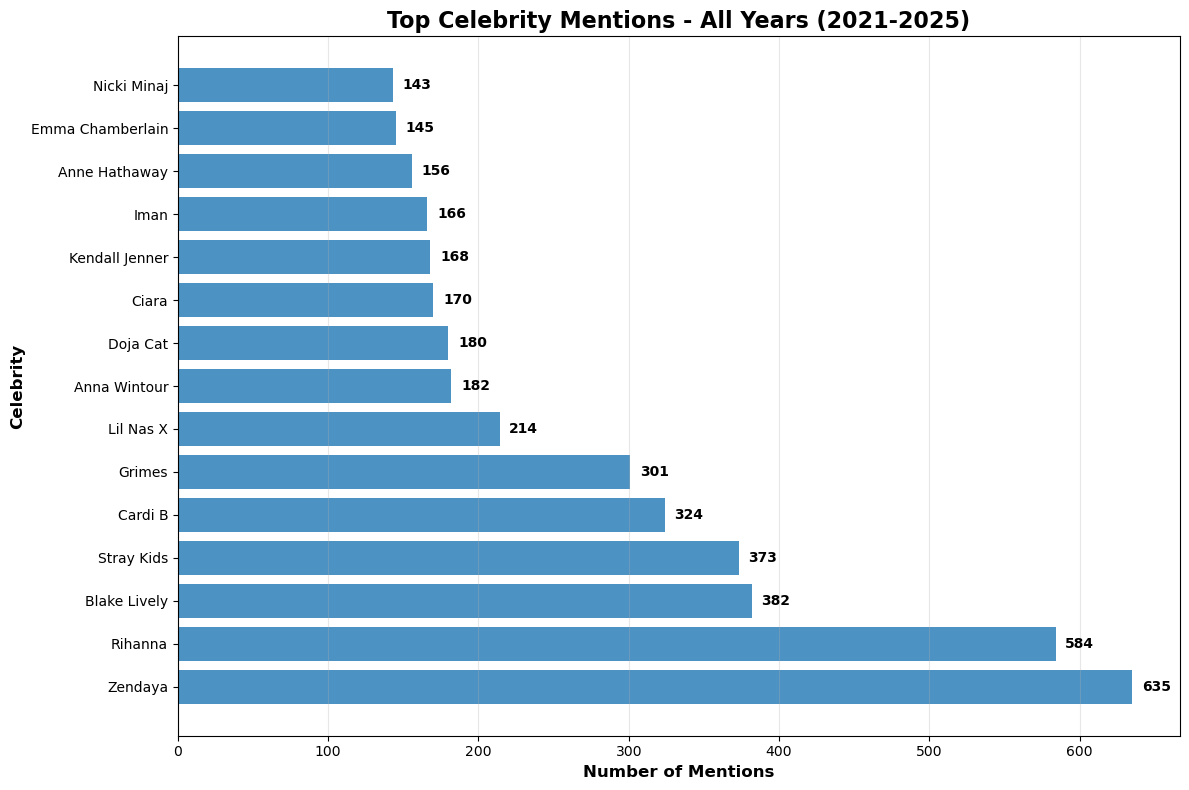


--- Summary ---
Created blue bar charts for celebrity mentions:
  2021: 2553 total mentions, 107 unique celebrities
  2022: 1388 total mentions, 74 unique celebrities
  2023: 1067 total mentions, 49 unique celebrities
  2024: 1617 total mentions, 64 unique celebrities
  2025: 1966 total mentions, 104 unique celebrities
  All Years: 8591 total mentions, 286 unique celebrities

=== Analysis Complete! ===
Year filtering applied: Celebrities only counted in years they attended
GraphML files saved in 'comention_graphs' directory:
- All-years graph: celeb_comentions_all_years.graphml
- 2021 graph: celeb_comentions_2021.graphml
- 2022 graph: celeb_comentions_2022.graphml
- 2023 graph: celeb_comentions_2023.graphml
- 2024 graph: celeb_comentions_2024.graphml
- 2025 graph: celeb_comentions_2025.graphml


In [2]:
import json
import pandas as pd
import re
import networkx as nx
from itertools import combinations
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

print(f"Attendees CSV columns: {list(celeb_df.columns)}")
print(f"Comments CSV columns: {list(comments_df.columns)}")

# --- Step 2: Text preprocessing function (for celebrity names only) ---
def preprocess_text(text):
    """Preprocess celebrity names for better matching with already-preprocessed comments"""
    if pd.isna(text) or text == "":
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove extra whitespace and normalize
    text = re.sub(r'\s+', ' ', text)
    
    # Remove common punctuation that might interfere with name matching
    text = re.sub(r'[^\w\s\'-]', ' ', text)
    
    # Handle common variations
    text = re.sub(r'\bkim\s*k\b', 'kim kardashian', text)
    text = re.sub(r'\bkardashian\b', 'kim kardashian', text)  
    text = re.sub(r'\bzendaya\b', 'zendaya', text)
    text = re.sub(r'\btaylor\s*swift\b', 'taylor swift', text)
    text = re.sub(r'\bt\s*swift\b', 'taylor swift', text)
    text = re.sub(r'\bbeyonce\b', 'beyonce', text)
    text = re.sub(r'\bbey\b', 'beyonce', text)
    text = re.sub(r'\bjlo\b', 'jennifer lopez', text)
    text = re.sub(r'\bj\s*lo\b', 'jennifer lopez', text)
    text = re.sub(r'\bariana\b', 'ariana grande', text)
    text = re.sub(r'\bari\b', 'ariana grande', text)
    text = re.sub(r'\bselena\b', 'selena gomez', text)
    text = re.sub(r'\briri\b', 'rihanna', text)
    text = re.sub(r'\bgaga\b', 'lady gaga', text)
    text = re.sub(r'\blady\s*gaga\b', 'lady gaga', text)
    text = re.sub(r'\bdua\b', 'dua lipa', text)
    text = re.sub(r'\bbillie\b', 'billie eilish', text)
    text = re.sub(r'\bthe\s*weeknd\b', 'the weeknd', text)
    text = re.sub(r'\bweeknd\b', 'the weeknd', text)
    
    return text.strip()

# Create mapping of celebrity -> years they attended
# Only preprocess celebrity names, comments are already preprocessed
celeb_year_mapping = {}
for index, row in celeb_df.iterrows():
    name = row.get('Name')
    year = row.get('Year')  # Attendees CSV uses 'Year' column (capital Y)
    
    if pd.notna(name) and pd.notna(year):
        processed_name = preprocess_text(name)  # Preprocess celebrity name to match preprocessed comments
        if processed_name:
            if processed_name not in celeb_year_mapping:
                celeb_year_mapping[processed_name] = set()
            celeb_year_mapping[processed_name].add(year)

print(f"\nLoaded celebrity attendance data for {len(celeb_year_mapping)} celebrities:")
for celeb, years in list(celeb_year_mapping.items())[:10]:  # Show first 10 as example
    print(f"  {celeb}: {sorted(years)}")
if len(celeb_year_mapping) > 10:
    print(f"  ... and {len(celeb_year_mapping) - 10} more")

# --- Step 3: Setup celebrity patterns (full names only) ---
raw_celeb_names = celeb_df['Name'].dropna().unique()

# Create mapping system for full names only
celeb_name_mapping = {}
all_patterns = []

for original_name in raw_celeb_names:
    processed_name = preprocess_text(original_name)
    if not processed_name:
        continue
    
    # Store the canonical name (full name only)
    canonical_name = processed_name
    
    # Add full name pattern only
    celeb_name_mapping[processed_name] = canonical_name
    all_patterns.append((processed_name, canonical_name, len(processed_name)))

# Sort patterns by length (longest first) for better matching
all_patterns.sort(key=lambda x: x[2], reverse=True)
pattern_strings = [re.escape(pattern[0]) for pattern in all_patterns]

celeb_regex = re.compile(r'\b(?:' + '|'.join(pattern_strings) + r')\b', re.IGNORECASE)

print(f"Loaded {len(raw_celeb_names)} celebrity names")
print(f"Created {len(pattern_strings)} search patterns (full names only)")
print(f"Loaded {len(comments_df)} comments")

# --- Step 4: Create output directory and data collection structures ---
output_dir = "comention_graphs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Data collection structures for plotting
celebrity_mentions_by_year = defaultdict(lambda: defaultdict(int))  # {year: {celebrity: count}}
celebrity_mentions_overall = defaultdict(int)  # {celebrity: total_count}
yearly_totals = defaultdict(int)  # {year: total_mentions}

# --- Step 5: Function to extract celebrity mentions with year filtering ---
def extract_mentions(text, comment_year):
    """Extract celebrity mentions from text (text is already preprocessed)"""
    if pd.isna(text) or text == "":
        return []
    
    # Text is already preprocessed, use as-is
    processed_text = str(text).lower()
    
    # Find all matches with their positions
    matches = []
    for match in celeb_regex.finditer(processed_text):
        match_text = match.group().lower()
        if match_text in celeb_name_mapping:
            celebrity_name = celeb_name_mapping[match_text]
            
            # Only include if celebrity attended in this comment's year
            if celebrity_name in celeb_year_mapping and comment_year in celeb_year_mapping[celebrity_name]:
                matches.append((match.start(), match.end(), match_text, celebrity_name))
    
    # Remove overlapping matches (prefer longer matches)
    matches.sort(key=lambda x: x[0])
    
    non_overlapping = []
    for i, (start, end, match_text, canonical) in enumerate(matches):
        # Check if this match overlaps with any previously accepted match
        overlaps = False
        for prev_start, prev_end, _, _ in non_overlapping:
            if not (end <= prev_start or start >= prev_end):  # They overlap
                overlaps = True
                break
        
        if not overlaps:
            non_overlapping.append((start, end, match_text, canonical))
    
    # Extract unique celebrity names (remove duplicates where same person mentioned multiple times)
    celebrity_mentions = set()
    for _, _, _, canonical in non_overlapping:
        celebrity_mentions.add(canonical)
    
    return list(celebrity_mentions)

# --- Step 6: Function to create co-mention graph and collect mention data ---
def create_comention_graph(df, year_filter=None, collect_data=False):
    """Create co-mention graph for celebrities mentioned together and optionally collect mention data"""
    G = nx.Graph()
    
    # Filter by year if specified
    if year_filter:
        df = df[df['met_gala_year'] == year_filter]
        graph_name = f"Met Gala {year_filter}"
    else:
        graph_name = "All Years"
    
    print(f"\n=== Processing {graph_name} ===")
    print(f"Processing {len(df)} comments...")
    
    mention_count = 0
    total_mentions = 0
    
    # Process each comment
    for index, row in df.iterrows():
        # Extract text and year from the comment
        comment_text = str(row.get('text', ''))
        comment_year = row.get('met_gala_year')  # Extract the comment year!
        
        if pd.isna(comment_year):
            continue
        
        # Find mentioned celebrities (filtered by year they attended)
        mentioned = extract_mentions(comment_text, comment_year)
        total_mentions += len(mentioned)
        
        # Collect data for plotting if requested
        if collect_data:
            for celebrity in mentioned:
                celebrity_mentions_by_year[comment_year][celebrity] += 1
                celebrity_mentions_overall[celebrity] += 1
                yearly_totals[comment_year] += 1
        
        if len(mentioned) > 1:
            mention_count += 1
            # Create edges for all pairs of mentioned celebrities
            for celeb1, celeb2 in combinations(sorted(mentioned), 2):
                if G.has_edge(celeb1, celeb2):
                    G[celeb1][celeb2]['weight'] += 1
                else:
                    G.add_edge(celeb1, celeb2, weight=1)
    
    return G, mention_count, total_mentions, graph_name

# --- Step 7: Function to analyze graph ---
def analyze_comention_graph(G, mention_count, total_mentions, graph_name, df_size):
    """Analyze and print co-mention graph statistics"""
    print(f"\n=== {graph_name} Co-mention Graph Summary ===")
    print(f"Total comments processed: {df_size}")
    print(f"Total celebrity mentions: {total_mentions}")
    print(f"Comments with multiple celebrity mentions: {mention_count}")
    print(f"Nodes (Celebrities): {G.number_of_nodes()}")
    print(f"Edges (Co-mentions): {G.number_of_edges()}")
    
    if G.number_of_edges() == 0:
        print("No co-mentions found for this period.")
        return
    
    # Top co-mentions
    print(f"\n--- Top 10 Celebrity Co-mentions ({graph_name}) ---")
    edges_with_weights = [(u, v, data['weight']) for u, v, data in G.edges(data=True)]
    edges_with_weights.sort(key=lambda x: x[2], reverse=True)
    
    for i, (celeb1, celeb2, weight) in enumerate(edges_with_weights[:10]):
        print(f"{i+1}. {celeb1.title()} & {celeb2.title()}: {weight} co-mentions")
    
    # Most connected celebrities
    print(f"\n--- Most Connected Celebrities ({graph_name}) ---")
    if G.number_of_nodes() > 0:
        degrees = dict(G.degree())
        sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
        
        for i, (celeb, degree) in enumerate(sorted_degrees[:10]):
            print(f"{i+1}. {celeb.title()}: {degree} connections")
    
    # Additional statistics
    if G.number_of_nodes() > 0:
        print(f"\n--- Network Statistics ({graph_name}) ---")
        print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
        
        # Most frequently co-mentioned pairs
        total_weight = sum([data['weight'] for u, v, data in G.edges(data=True)])
        print(f"Total co-mention instances: {total_weight}")
        
        if G.number_of_edges() > 0:
            avg_weight = total_weight / G.number_of_edges()
            print(f"Average co-mentions per pair: {avg_weight:.2f}")

# --- Step 8: Function to save graph ---
def save_comention_graph(G, graph_name, year_filter=None):
    """Save co-mention graph as GraphML file"""
    if year_filter:
        filename = f"celeb_comentions_{year_filter}.graphml"
    else:
        filename = "celeb_comentions_all_years.graphml"
    
    filepath = os.path.join(output_dir, filename)
    nx.write_graphml(G, filepath)
    print(f"Saved {graph_name} graph: {filepath}")

# --- Step 9: Create and analyze all-years graph (with data collection) ---
G_all, mentions_all, total_mentions_all, name_all = create_comention_graph(comments_df, collect_data=True)
analyze_comention_graph(G_all, mentions_all, total_mentions_all, name_all, len(comments_df))
save_comention_graph(G_all, name_all)

# --- Step 10: Create and analyze individual year graphs ---
unique_years = sorted(comments_df['met_gala_year'].dropna().unique())
print(f"\n=== Found {len(unique_years)} unique years: {unique_years} ===")

year_graphs = {}
for year in unique_years:
    year_df = comments_df[comments_df['met_gala_year'] == year]
    G_year, mentions_year, total_mentions_year, name_year = create_comention_graph(comments_df, year)
    
    if G_year.number_of_nodes() > 0:  # Only analyze if graph has data
        analyze_comention_graph(G_year, mentions_year, total_mentions_year, name_year, len(year_df))
        save_comention_graph(G_year, name_year, year)
        year_graphs[year] = G_year
    else:
        print(f"No co-mentions found for {year}")

# --- Step 11: Cross-year comparison ---
print(f"\n=== Cross-Year Co-mention Comparison ===")
for year in unique_years:
    if year in year_graphs:
        G = year_graphs[year]
        total_weight = sum([data['weight'] for u, v, data in G.edges(data=True)])
        print(f"{year}: {G.number_of_nodes()} celebrities, {G.number_of_edges()} pairs, {total_weight} total co-mentions")

# --- Step 12: Most mentioned celebrities across all data (with year filtering) ---
print(f"\n=== Most Mentioned Celebrities (All Years, Year-Filtered) ===")
all_celebrity_mentions = []
for index, row in comments_df.iterrows():
    comment_text = str(row.get('text', ''))
    comment_year = row.get('met_gala_year')
    
    if pd.notna(comment_year):
        mentioned = extract_mentions(comment_text, comment_year)
        all_celebrity_mentions.extend(mentioned)

if all_celebrity_mentions:
    mention_counts = Counter(all_celebrity_mentions)
    
    for i, (celeb, count) in enumerate(mention_counts.most_common(15)):
        # Show which years this celebrity attended
        years_attended = sorted(celeb_year_mapping.get(celeb, []))
        print(f"{i+1}. {celeb.title()}: mentioned {count} times (attended: {years_attended})")
else:
    print("No valid celebrity mentions found after year filtering")

# --- Step 13: Year-specific mention analysis ---
print(f"\n=== Celebrity Mentions by Year ===")
for year in unique_years:
    year_comments = comments_df[comments_df['met_gala_year'] == year]
    year_mentions = []
    
    for index, row in year_comments.iterrows():
        comment_text = str(row.get('text', ''))
        comment_year = row.get('met_gala_year')
        if pd.notna(comment_year):
            mentioned = extract_mentions(comment_text, comment_year)
            year_mentions.extend(mentioned)
    
    if year_mentions:
        year_counts = Counter(year_mentions)
        print(f"\n{year} - Top mentioned celebrities:")
        for i, (celeb, count) in enumerate(year_counts.most_common(5)):
            print(f"  {i+1}. {celeb.title()}: {count} mentions")
    else:
        print(f"\n{year} - No valid celebrity mentions found")

# --- Step 14: Create simplified blue bar chart visualizations ---
def create_celebrity_mention_plots():
    """Create blue bar charts showing top celebrity mentions for each year"""
    print(f"\n=== Creating Celebrity Mention Bar Charts ===")
    
    # Set up the plotting style
    plt.style.use('default')
    
    # Years to analyze
    years_to_plot = [2021, 2022, 2023, 2024, 2025]
    
    # Create individual year plots
    for year in years_to_plot:
        if year in celebrity_mentions_by_year and len(celebrity_mentions_by_year[year]) > 0:
            # Get top 15 celebrities for this year
            year_data = dict(celebrity_mentions_by_year[year])
            top_celebs = dict(Counter(year_data).most_common(15))
            
            if len(top_celebs) > 0:
                # Create figure
                fig, ax = plt.subplots(figsize=(12, 8))
                
                celeb_names = [name.title() for name in top_celebs.keys()]
                mention_counts = list(top_celebs.values())
                
                # Create horizontal bar chart in blue
                bars = ax.barh(celeb_names, mention_counts, color='#1f77b4', alpha=0.8)
                
                ax.set_xlabel('Number of Mentions', fontsize=12, fontweight='bold')
                ax.set_ylabel('Celebrity', fontsize=12, fontweight='bold')
                ax.set_title(f'Top Celebrity Mentions - Met Gala {year}', fontsize=16, fontweight='bold')
                ax.grid(axis='x', alpha=0.3)
                
                # Add value labels on bars
                for bar, count in zip(bars, mention_counts):
                    ax.text(bar.get_width() + max(mention_counts) * 0.01, 
                           bar.get_y() + bar.get_height()/2, 
                           str(count), ha='left', va='center', fontweight='bold')
                
                # Adjust layout
                plt.tight_layout()
                
                # Save the plot
                plot_path = os.path.join(output_dir, f'celebrity_mentions_{year}.png')
                plt.savefig(plot_path, dpi=300, bbox_inches='tight')
                print(f"Saved {year} celebrity mentions chart: {plot_path}")
                
                plt.show()
                plt.close()
            else:
                print(f"No celebrity mention data found for {year}")
        else:
            print(f"No data available for {year}")
    
    # Create overall chart (all years combined)
    if len(celebrity_mentions_overall) > 0:
        # Get top 15 celebrities overall
        top_celebs_overall = dict(Counter(celebrity_mentions_overall).most_common(15))
        
        # Create figure
        fig, ax = plt.subplots(figsize=(12, 8))
        
        celeb_names = [name.title() for name in top_celebs_overall.keys()]
        mention_counts = list(top_celebs_overall.values())
        
        # Create horizontal bar chart in blue
        bars = ax.barh(celeb_names, mention_counts, color='#1f77b4', alpha=0.8)
        
        ax.set_xlabel('Number of Mentions', fontsize=12, fontweight='bold')
        ax.set_ylabel('Celebrity', fontsize=12, fontweight='bold')
        ax.set_title('Top Celebrity Mentions - All Years (2021-2025)', fontsize=16, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels on bars
        for bar, count in zip(bars, mention_counts):
            ax.text(bar.get_width() + max(mention_counts) * 0.01, 
                   bar.get_y() + bar.get_height()/2, 
                   str(count), ha='left', va='center', fontweight='bold')
        
        # Adjust layout
        plt.tight_layout()
        
        # Save the plot
        plot_path = os.path.join(output_dir, 'celebrity_mentions_all_years.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Saved all years celebrity mentions chart: {plot_path}")
        
        plt.show()
        plt.close()
    
    # Show summary
    print(f"\n--- Summary ---")
    print(f"Created blue bar charts for celebrity mentions:")
    for year in years_to_plot:
        if year in celebrity_mentions_by_year and len(celebrity_mentions_by_year[year]) > 0:
            total_mentions = sum(celebrity_mentions_by_year[year].values())
            unique_celebs = len(celebrity_mentions_by_year[year])
            print(f"  {year}: {total_mentions} total mentions, {unique_celebs} unique celebrities")
    
    total_overall = sum(celebrity_mentions_overall.values())
    unique_overall = len(celebrity_mentions_overall)
    print(f"  All Years: {total_overall} total mentions, {unique_overall} unique celebrities")

# Create the visualizations
create_celebrity_mention_plots()

print(f"\n=== Analysis Complete! ===")
print(f"Year filtering applied: Celebrities only counted in years they attended")
print(f"GraphML files saved in '{output_dir}' directory:")
print(f"- All-years graph: celeb_comentions_all_years.graphml")
for year in unique_years:
    if year in year_graphs:
        print(f"- {year} graph: celeb_comentions_{year}.graphml")

Loaded 72076 comments

=== Processing All Years ===
Processing 72076 comments...

=== All Years Graph Summary ===
Unique videos: 22
Unique users: 52105
Total nodes: 52127
Total edges (user → video): 56224

--- Most Active Users (All Years) ---
1. nan: commented on 12 videos
2. @levjerraz6983: commented on 9 videos
3. @pollycipher: commented on 7 videos
4. @krishniarumugam: commented on 7 videos
5. @babybluecheeks: commented on 7 videos
6. @johnpearson1258: commented on 6 videos
7. @hautelemode: commented on 6 videos
8. @duchessedeberne3909: commented on 6 videos
9. @CARATMom: commented on 6 videos
10. @charlottemccaig578: commented on 6 videos

--- Most Popular Videos (All Years) ---
1. Video NW2oiPiqByk (2025): 8300 unique commenters
2. Video ZMrgtotgThk (2021): 7189 unique commenters
3. Video PbRZcvVnF0w (2022): 5294 unique commenters
4. Video P71sr0kZY7o (2024): 4566 unique commenters
5. Video AyFzKATCiv0 (2025): 4070 unique commenters
6. Video jlR-T42I18E (2024): 3086 unique commen

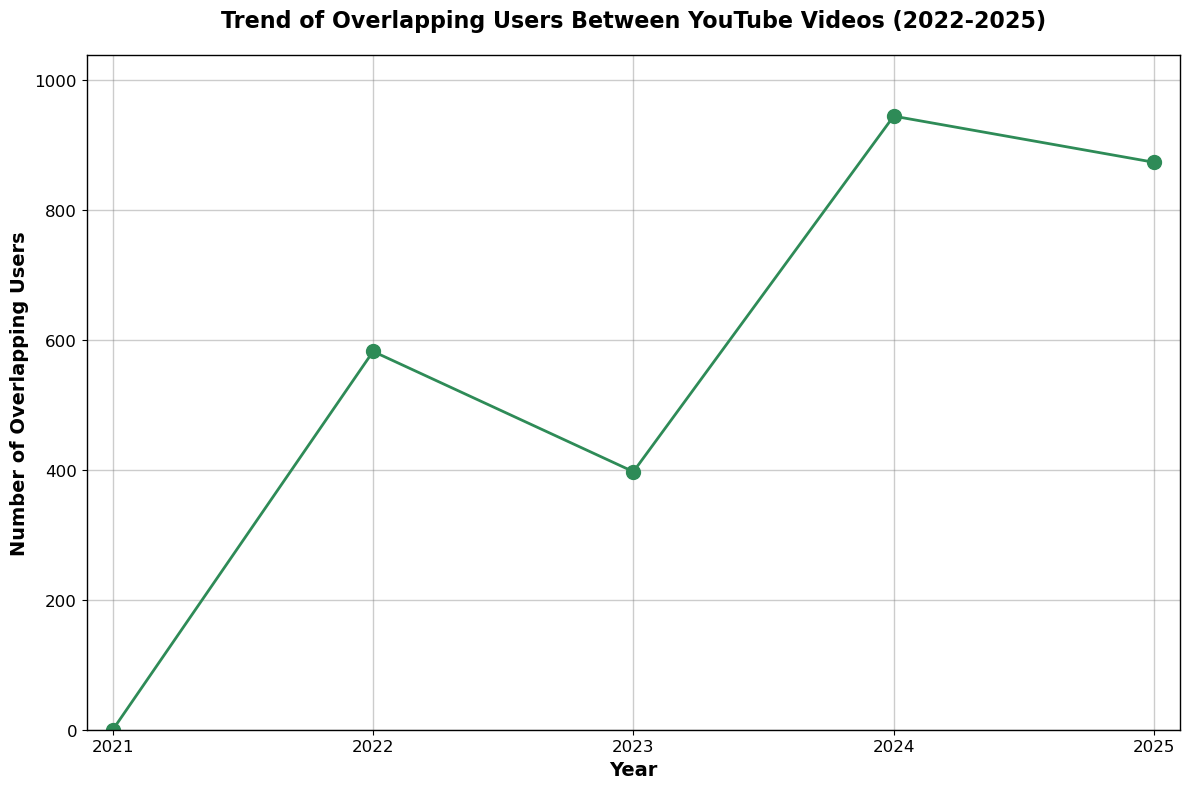


=== Detailed Overlap Analysis ===
2021 → 2022: 582 continuing users (5.5% retention)
2022 → 2023: 269 continuing users (2.5% retention)
2023 → 2024: 302 continuing users (7.7% retention)
2024 → 2025: 529 continuing users (4.2% retention)
Saved user retention visualization: reply_graphs/user_retention_rates.png


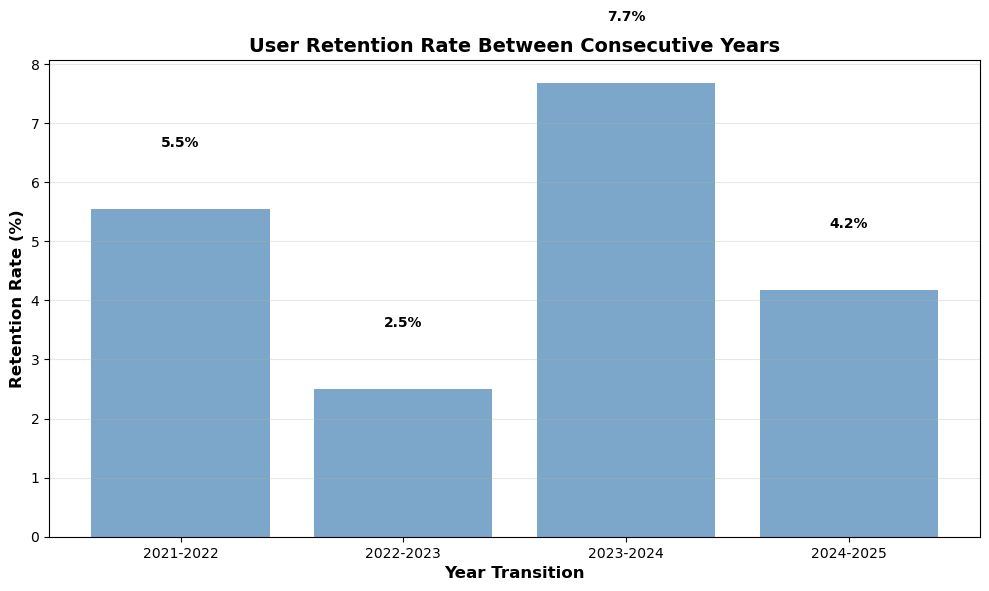


=== Cross-Year Comparison ===
2021: 10496 nodes, 10613 edges
2022: 10775 nodes, 11090 edges
2023: 3935 nodes, 4060 edges
2024: 12666 nodes, 12805 edges
2025: 17051 nodes, 17656 edges

=== Users Active Across Multiple Years ===
- @ytuseracct: active in 5 years (2021, 2022, 2023, 2024, 2025) - 20 total comments
- @DeeJKerei: active in 5 years (2021, 2022, 2023, 2024, 2025) - 23 total comments
- @CorettaJG: active in 5 years (2021, 2022, 2023, 2024, 2025) - 12 total comments
- @hautelemode: active in 5 years (2021, 2022, 2023, 2024, 2025) - 26 total comments
- @MelissaRae1975: active in 5 years (2021, 2022, 2023, 2024, 2025) - 5 total comments
- @Sera-Marie: active in 5 years (2021, 2022, 2023, 2024, 2025) - 10 total comments
- @TVandManga: active in 5 years (2021, 2022, 2023, 2024, 2025) - 5 total comments
- @duchessedeberne3909: active in 5 years (2021, 2022, 2023, 2024, 2025) - 7 total comments
- @professionalcommenter: active in 5 years (2021, 2022, 2023, 2024, 2025) - 13 total comme

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import os

# --- Step 1: Load YouTube comments data ---
print(f"Loaded {len(comments_df)} comments")

# --- Step 2: Create output directory for graphs ---
output_dir = "reply_graphs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# --- Step 3: Function to create directed graph ---
def create_directed_graph(df, year_filter=None):
    """Create directed graph where users point to videos they commented on"""
    G = nx.DiGraph()  # Directed graph
    
    # Filter by year if specified
    if year_filter:
        df = df[df['met_gala_year'] == year_filter]
        graph_name = f"Met Gala {year_filter}"
    else:
        graph_name = "All Years"
    
    # Track node types
    video_nodes = set()
    user_nodes = set()
    video_info = {}
    
    print(f"\n=== Processing {graph_name} ===")
    print(f"Processing {len(df)} comments...")
    
    for index, row in df.iterrows():
        video_id = str(row.get('video_id', ''))
        author = str(row.get('author', ''))
        met_gala_year = str(row.get('met_gala_year', ''))
        
        # Skip if essential data is missing
        if pd.isna(video_id) or pd.isna(author) or video_id == '' or author == '':
            continue
        
        # Create video node (just the video_id as requested)
        video_node = f"{video_id}_{met_gala_year}"
        video_info[video_node] = (video_id, met_gala_year)
        
        # Add nodes to respective sets
        video_nodes.add(video_node)
        user_nodes.add(author)
        
        # Add directed edge: user -> video (user comments on video)
        if G.has_edge(author, video_node):
            G[author][video_node]['weight'] += 1
        else:
            G.add_edge(author, video_node, weight=1)
    
    return G, video_nodes, user_nodes, video_info, graph_name

# --- Step 4: Function to analyze graph ---
def analyze_graph(G, video_nodes, user_nodes, video_info, graph_name):
    """Analyze and print graph statistics"""
    print(f"\n=== {graph_name} Graph Summary ===")
    print(f"Unique videos: {len(video_nodes)}")
    print(f"Unique users: {len(user_nodes)}")
    print(f"Total nodes: {G.number_of_nodes()}")
    print(f"Total edges (user → video): {G.number_of_edges()}")
    
    if G.number_of_nodes() == 0:
        print("No data to analyze for this period.")
        return
    
    # Most active users (highest out-degree - commenting on most videos)
    print(f"\n--- Most Active Users ({graph_name}) ---")
    user_out_degrees = {}
    for node in G.nodes():
        if node in user_nodes:
            user_out_degrees[node] = G.out_degree(node)
    
    if user_out_degrees:
        sorted_users = sorted(user_out_degrees.items(), key=lambda x: x[1], reverse=True)
        for i, (user, degree) in enumerate(sorted_users[:10]):
            print(f"{i+1}. {user}: commented on {degree} videos")
    
    # Most popular videos (highest in-degree - most users commenting)
    print(f"\n--- Most Popular Videos ({graph_name}) ---")
    video_in_degrees = {}
    for node in G.nodes():
        if node in video_nodes:
            video_in_degrees[node] = G.in_degree(node)
    
    if video_in_degrees:
        sorted_videos = sorted(video_in_degrees.items(), key=lambda x: x[1], reverse=True)
        for i, (video_node, degree) in enumerate(sorted_videos[:10]):
            video_id, year = video_info[video_node]
            print(f"{i+1}. Video {video_id} ({year}): {degree} unique commenters")
    
    # Comment volume analysis (edge weights)
    print(f"\n--- Highest Comment Volumes ({graph_name}) ---")
    edges_with_weights = []
    for user, video, data in G.edges(data=True):
        if user in user_nodes:  # user -> video edge
            video_id, year = video_info[video]
            edges_with_weights.append((user, video_id, year, data['weight']))
    
    if edges_with_weights:
        edges_with_weights.sort(key=lambda x: x[3], reverse=True)
        for i, (user, video_id, year, weight) in enumerate(edges_with_weights[:10]):
            print(f"{i+1}. {user} → Video {video_id} ({year}): {weight} comments")

# --- Step 5: Function to save graph ---
def save_graph(G, video_nodes, user_nodes, video_info, graph_name, year_filter=None):
    """Save graph as GraphML file"""
    if year_filter:
        filename_base = f"reply_graph_{year_filter}"
    else:
        filename_base = "reply_graph_all_years"
    
    # Save as GraphML
    graphml_path = os.path.join(output_dir, f"{filename_base}.graphml")
    nx.write_graphml(G, graphml_path)
    
    print(f"Saved {graph_name} graph: {graphml_path}")

# --- Step 6: Create and analyze all-years graph ---
G_all, video_nodes_all, user_nodes_all, video_info_all, name_all = create_directed_graph(comments_df)
analyze_graph(G_all, video_nodes_all, user_nodes_all, video_info_all, name_all)
save_graph(G_all, video_nodes_all, user_nodes_all, video_info_all, name_all)

# --- Step 7: Create and analyze individual year graphs ---
unique_years = sorted(comments_df['met_gala_year'].dropna().unique())
print(f"\n=== Found {len(unique_years)} unique years: {unique_years} ===")

year_graphs = {}
year_users = {}  # Store users for each year for overlap analysis

for year in unique_years:
    G_year, video_nodes_year, user_nodes_year, video_info_year, name_year = create_directed_graph(comments_df, year)
    
    if G_year.number_of_nodes() > 0:  # Only analyze if graph has data
        analyze_graph(G_year, video_nodes_year, user_nodes_year, video_info_year, name_year)
        save_graph(G_year, video_nodes_year, user_nodes_year, video_info_year, name_year, year)
        year_graphs[year] = G_year
        year_users[year] = user_nodes_year  # Store users for this year
    else:
        print(f"No data found for {year}")

# --- Step 8: Community Overlap Analysis ---
def analyze_community_overlap(year_users, unique_years):
    """Analyze overlapping users between consecutive years and create visualization"""
    print(f"\n=== Community Overlap Analysis ===")
    
    # Calculate overlapping users between consecutive years
    overlap_data = []
    overlap_counts = []
    
    for i in range(len(unique_years)):
        current_year = unique_years[i]
        
        if current_year not in year_users:
            continue
            
        current_users = year_users[current_year]
        
        # Calculate overlap with all previous years (cumulative community)
        all_previous_users = set()
        for j in range(i):
            prev_year = unique_years[j]
            if prev_year in year_users:
                all_previous_users.update(year_users[prev_year])
        
        if all_previous_users:
            overlapping_users = current_users.intersection(all_previous_users)
            overlap_count = len(overlapping_users)
        else:
            overlap_count = 0
        
        overlap_data.append((current_year, overlap_count, len(current_users)))
        overlap_counts.append(overlap_count)
        
        print(f"{current_year}: {overlap_count} overlapping users from previous years (Total users: {len(current_users)})")
    
    return overlap_data, overlap_counts

def create_overlap_visualization(overlap_data, unique_years):
    """Create line plot showing community overlap over time - YouTube style"""
    print(f"\n=== Creating Community Overlap Visualization ===")
    
    if len(overlap_data) < 2:
        print("Not enough data to create overlap visualization")
        return
    
    # Extract data for plotting
    years = [data[0] for data in overlap_data]
    overlap_counts = [data[1] for data in overlap_data]
    
    # Create the plot with exact styling to match the reference image
    plt.figure(figsize=(12, 8))
    
    # Create line plot with markers (matching the reference style exactly)
    plt.plot(years, overlap_counts, marker='o', linewidth=2, markersize=10, 
             color='#2E8B57', markerfacecolor='#2E8B57', markeredgecolor='#2E8B57')
    
    # Customize the plot to match the reference image exactly
    plt.title('Trend of Overlapping Users Between YouTube Videos (2022-2025)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Year', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Overlapping Users', fontsize=14, fontweight='bold')
    
    # Add grid that matches the reference style
    plt.grid(True, alpha=0.4, linewidth=1, color='gray')
    
    # Set axis properties to match reference
    plt.xticks(years, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Set y-axis to start from 0 and add some padding at the top
    plt.ylim(0, max(overlap_counts) * 1.1)
    
    # Make sure all years are shown on x-axis
    plt.xlim(min(years) - 0.1, max(years) + 0.1)
    
    # Add subtle border around the plot area
    ax = plt.gca()
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    
    # Adjust layout with proper margins
    plt.tight_layout()
    
    # Save the plot
    plot_path = os.path.join(output_dir, 'youtube_community_overlap_trend.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Saved YouTube community overlap visualization: {plot_path}")
    
    plt.show()

def create_detailed_overlap_analysis(year_users, unique_years):
    """Create additional overlap analysis and visualizations"""
    print(f"\n=== Detailed Overlap Analysis ===")
    
    # Year-to-year transition analysis
    consecutive_overlaps = []
    
    for i in range(1, len(unique_years)):
        prev_year = unique_years[i-1]
        curr_year = unique_years[i]
        
        if prev_year in year_users and curr_year in year_users:
            prev_users = year_users[prev_year]
            curr_users = year_users[curr_year]
            
            overlap = prev_users.intersection(curr_users)
            retention_rate = len(overlap) / len(prev_users) * 100 if len(prev_users) > 0 else 0
            
            consecutive_overlaps.append((f"{prev_year}-{curr_year}", len(overlap), retention_rate))
            print(f"{prev_year} → {curr_year}: {len(overlap)} continuing users ({retention_rate:.1f}% retention)")
    
    # Create retention rate visualization
    if consecutive_overlaps:
        transitions = [item[0] for item in consecutive_overlaps]
        retention_rates = [item[2] for item in consecutive_overlaps]
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(transitions, retention_rates, color='steelblue', alpha=0.7)
        
        plt.title('User Retention Rate Between Consecutive Years', fontsize=14, fontweight='bold')
        plt.xlabel('Year Transition', fontsize=12, fontweight='bold')
        plt.ylabel('Retention Rate (%)', fontsize=12, fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar, rate in zip(bars, retention_rates):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                    f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        
        # Save the plot
        retention_path = os.path.join(output_dir, 'user_retention_rates.png')
        plt.savefig(retention_path, dpi=300, bbox_inches='tight')
        print(f"Saved user retention visualization: {retention_path}")
        
        plt.show()

# Run overlap analysis
overlap_data, overlap_counts = analyze_community_overlap(year_users, unique_years)
create_overlap_visualization(overlap_data, unique_years)
create_detailed_overlap_analysis(year_users, unique_years)

# --- Step 9: Cross-year comparison ---
print(f"\n=== Cross-Year Comparison ===")
for year in unique_years:
    if year in year_graphs:
        G = year_graphs[year]
        print(f"{year}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# --- Step 10: Users active across multiple years ---
print(f"\n=== Users Active Across Multiple Years ===")
user_years = comments_df.groupby('author')['met_gala_year'].nunique().sort_values(ascending=False)
multi_year_users = user_years[user_years > 1]

if len(multi_year_users) > 0:
    for user, year_count in multi_year_users.head(10).items():
        years = sorted(comments_df[comments_df['author'] == user]['met_gala_year'].unique())
        total_comments = len(comments_df[comments_df['author'] == user])
        print(f"- {user}: active in {year_count} years ({', '.join(map(str, years))}) - {total_comments} total comments")
else:
    print("No users found commenting across multiple years")

print(f"\n=== Analysis Complete! ===")
print(f"GraphML files and visualizations saved in '{output_dir}' directory:")
print(f"- All-years graph: reply_graph_all_years.graphml")
print(f"- Community overlap trend: community_overlap_trend.png")
print(f"- User retention rates: user_retention_rates.png")
for year in unique_years:
    if year in year_graphs:
        print(f"- {year} graph: reply_graph_{year}.graphml")